In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [43]:
# Creating Tensors
t1 = torch.tensor([1., 2., 3., 4.]) # Vector`
t2 = torch.tensor([[1., 2, 3], [4, 5, 6]]) # Matrix
t3 = torch.tensor([[[1, 2, 3],
					[4, 5, 6]],
				    [[15, 16, 17],
					[18, 19, 20]]]) # 3D Matrix
					
print(t1.shape)
print(t2.shape)
print(t3.shape)

torch.Size([4])
torch.Size([2, 3])
torch.Size([2, 2, 3])


In [44]:
x = torch.tensor([3., 2., 7.])
w = torch.tensor([4., 1., 2.], requires_grad = True)
b = torch.tensor([5.], requires_grad = True)

y = w@x + b
print(y)

tensor([33.], grad_fn=<AddBackward0>)


In [45]:
# inputs (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
					[91, 88, 64],
					[87, 134, 58],
					[102, 43, 37],
					[69, 96, 70]], dtype = 'float32')

# (Apples, Oranges)
targets = np.array([[56, 70],
					[81, 101],
					[119, 133],
					[22, 37],
					[103, 119]], dtype = 'float32')
										
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [46]:
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(2, requires_grad=True)

def model(x):
	return x @ w.t() + b  # @ in Pytorch is for matrix multiplication

def mse(predictions, labels):
	diff = predictions - labels
	return torch.sum(diff * diff) / (2 * labels.numel())
	
preds = model(inputs)
loss = mse(preds, targets)
print(preds)
print(loss)

tensor([[  14.4616,  -87.4278],
        [  32.1212, -125.9957],
        [  29.2414,  -97.0258],
        [ -11.7589,  -98.5631],
        [  53.3276, -123.7768]], grad_fn=<AddBackward0>)
tensor(11115.9277, grad_fn=<DivBackward0>)


In [48]:
loss.backward()
print(w.grad)
print(b.grad)
print(w.grad.zero_())
print(b.grad.zero_()) # We need to reset gradients to zero because Pytorch tracks gradients.

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [49]:
preds = model(inputs)
loss = mse(preds, targets)
print(loss)
loss.backward()
print(preds)
for i in range(1000):
	with torch.no_grad():
		w -= w.grad * 1e-5
		b -= b.grad * 1e-5
		w.grad.zero_()
		b.grad.zero_()
preds = model(inputs)
loss = mse(preds, targets)
print(loss)
print(preds)

tensor(11115.9277, grad_fn=<DivBackward0>)
tensor([[  14.4616,  -87.4278],
        [  32.1212, -125.9957],
        [  29.2414,  -97.0258],
        [ -11.7589,  -98.5631],
        [  53.3276, -123.7768]], grad_fn=<AddBackward0>)
tensor(9244.0166, grad_fn=<DivBackward0>)
tensor([[  18.4152,  -72.8886],
        [  37.3174, -106.8774],
        [  35.4252,  -74.4161],
        [  -7.8597,  -84.1359],
        [  58.3281, -105.4150]], grad_fn=<AddBackward0>)


In [32]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [33]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

In [50]:
'''
We define split indices function to pick validation set (random 20%)
'''
def split_indices(n, val_pct):
	# Determine size of validation set
	n_val = int(val_pct*n)
	idxs = np.random.permutation(n)
	# Pick first n_val random indices for validation set
	return idxs[n_val:], idxs[:n_val]

In [51]:
train_indices, val_indices = split_indices(len(dataset), 0.2) # Train Test split
print(len(train_indices), len(val_indices))

48000 12000


In [52]:
'''
We can now create PyTorch dataloaders for each of the subsets using a SubsetRandomSampler, which samples
elements randomly from a given list of indices, while creating batches of data.
'''

batch_size = 100
# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
# Dataloader splits data into batches for training.

valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [57]:
input_size = 28*28 # replace with input size ofc loll
num_classes = 10 # num of output classes

class MNISTModel(nn.Module):
	def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
		super().__init__()
		self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim//2, output_dim)
        )
	
	def forward(self, x):
		x = x.view(x.size(0), -1) # Flatenning into tensors because image data for linear
		return self.network(x)
    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')	
model = MNISTModel(input_dim=input_size, hidden_dim=32, output_dim=num_classes).to(device)

In [58]:
ce_loss = nn.CrossEntropyLoss()
loss_fn = ce_loss # or mse_loss
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
def accuracy(outputs, labels):
    preds = outputs.argmax(dim=1)
    return (preds == labels).float().mean().item()
    
@torch.no_grad()
def evaluate(model, val_loader, loss_fn):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0

    for xb, yb in val_loader:
        logits = model(xb)
        loss = loss_fn(logits, yb)

        bs = xb.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy(logits, yb) * bs
        n += bs

    return total_loss / n, total_acc / n

def to_device(data, device):
	''' Move tensors to chosen device '''
	if isinstance(data, (list,tuple)):
		return [to_device(x, device) for x in data]
	return data.to(device, non_blocking=True)

for images, labels in train_dl:
	images = to_device(images, device)
	break

''' 
The device dataloader is defined because when we make batches of data we pass it to gpu
if we pass whole data to gpu at once we will hog gpu memory
'''
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
        
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [59]:
import torch
import matplotlib.pyplot as plt

def fit(model, train_loader, val_loader, loss_fn, optimizer, epochs=10, patience=5, plot=True):
    best_val_loss = float('inf')
    patience_counter = 0

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  []
    }

    for epoch in range(epochs):
        model.train()
        total_loss, total_acc, n = 0.0, 0.0, 0

        for xb, yb in train_loader:  # already on device
            logits = model(xb)
            loss = loss_fn(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            bs = xb.size(0)
            total_loss += loss.item() * bs
            total_acc  += accuracy(logits, yb) * bs
            n += bs

        train_loss = total_loss / n
        train_acc  = total_acc / n
        val_loss, val_acc = evaluate(model, val_loader, loss_fn)

        # store history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    if plot:
        epochs_ran = range(1, len(history["train_loss"]) + 1)

        plt.figure()
        plt.plot(epochs_ran, history["train_loss"], label="train loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.title("Loss curves")
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(epochs_ran, history["train_acc"], label="train acc")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.title("Accuracy curves")
        plt.legend()
        plt.show()

    return history

Epoch 1/10 | train_loss=0.9681 train_acc=0.7641 | val_loss=0.3551 val_acc=0.9199
Epoch 2/10 | train_loss=0.4943 train_acc=0.8592 | val_loss=0.2422 val_acc=0.9347
Epoch 3/10 | train_loss=0.4081 train_acc=0.8801 | val_loss=0.1995 val_acc=0.9426
Epoch 4/10 | train_loss=0.3710 train_acc=0.8883 | val_loss=0.1805 val_acc=0.9487
Epoch 5/10 | train_loss=0.3437 train_acc=0.8991 | val_loss=0.1696 val_acc=0.9534
Epoch 6/10 | train_loss=0.3285 train_acc=0.9025 | val_loss=0.1641 val_acc=0.9550
Epoch 7/10 | train_loss=0.3187 train_acc=0.9056 | val_loss=0.1552 val_acc=0.9569
Epoch 8/10 | train_loss=0.3089 train_acc=0.9086 | val_loss=0.1512 val_acc=0.9568
Epoch 9/10 | train_loss=0.2985 train_acc=0.9110 | val_loss=0.1517 val_acc=0.9566
Epoch 10/10 | train_loss=0.2846 train_acc=0.9141 | val_loss=0.1497 val_acc=0.9562


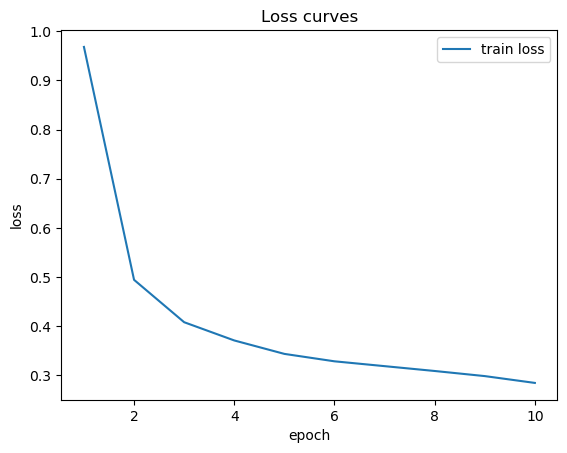

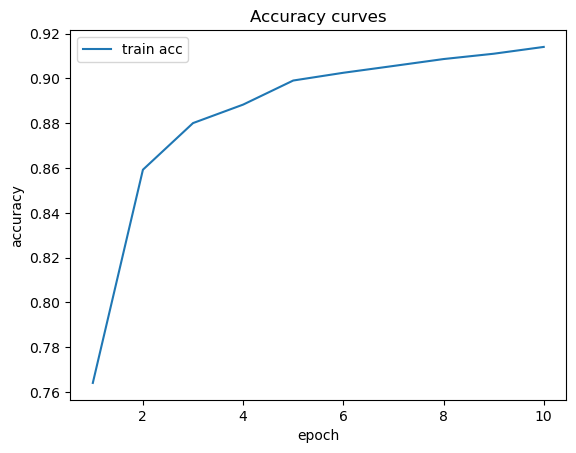

{'train_loss': [0.9681429603447517,
  0.494326666307946,
  0.4080829283222556,
  0.37098400422061484,
  0.34365253436068693,
  0.32854090727244817,
  0.31870683304344616,
  0.3088594955857843,
  0.2984720800537616,
  0.2845759492212286],
 'val_loss': [0.3550877186159293,
  0.2422235411281387,
  0.19953448344022034,
  0.1804656323045492,
  0.16962988122055928,
  0.16410897385018566,
  0.15524396151304246,
  0.15115285438175002,
  0.1516637302779903,
  0.14971590250109632],
 'train_acc': [0.7640624798213442,
  0.8592499809960524,
  0.8800624797741572,
  0.88831247985363,
  0.8990624816467364,
  0.9025208142896494,
  0.9055624824017287,
  0.9086458151539166,
  0.9110208122680584,
  0.9140624807526668],
 'val_acc': [0.9199166456858318,
  0.9347499832510948,
  0.9425833185513814,
  0.9487499803304672,
  0.9534166470170021,
  0.9549999783436457,
  0.9569166441758473,
  0.956833312412103,
  0.9565833106637001,
  0.9561666458845138]}

In [60]:
fit(model, train_dl, valid_dl, loss_fn, optim, epochs=10, patience=3)

In [42]:
model.eval()
# Make an example input with the right shape for MNIST: [B, 1, 28, 28]
example = torch.randn(1, 1, 28, 28, device=next(model.parameters()).device)

# Trace (works for most CNNs). If it fails, tell me the error and we’ll use script().
ts_model = torch.jit.trace(model, example)
ts_model.save("mnist_digit_model_ts.pt")

print("Saved TorchScript model -> mnist_digit_model_ts.pt")

Saved TorchScript model -> mnist_digit_model_ts.pt
